 1. Import Libraries

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE

2. Load Dataset

In [11]:
df = pd.read_csv('creditcard.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

3. Exploratory Data Analysis (EDA)

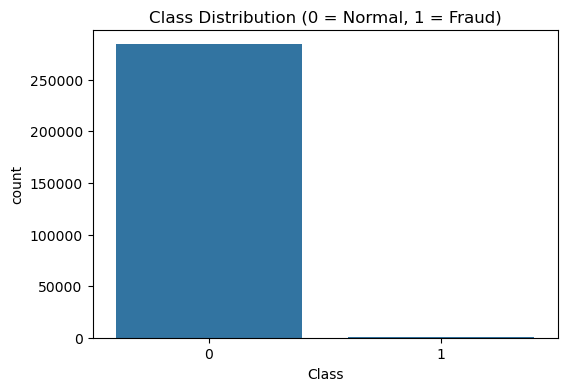

Percentage of fraudulent transactions: 0.1727%


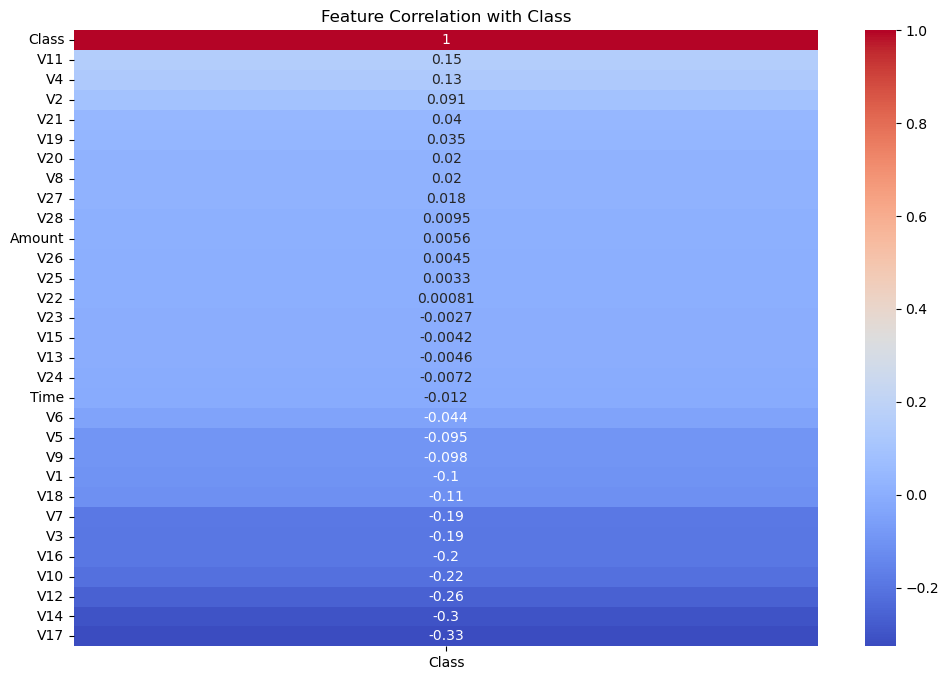

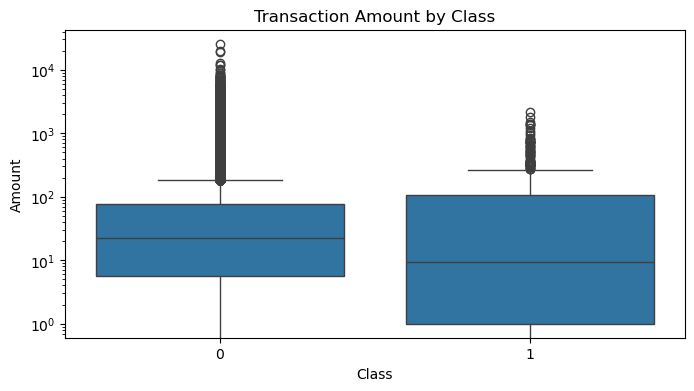

In [12]:
# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Normal, 1 = Fraud)')
plt.show()

# Percentage of fraud cases
fraud_percent = (df['Class'].sum() / len(df)) * 100
print(f"Percentage of fraudulent transactions: {fraud_percent:.4f}%")

# Correlation heatmap (focus on target and important features)
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Class')
plt.show()

# Distribution of 'Amount' by class
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount by Class')
plt.yscale('log')
plt.show()

4. Data Preprocessing

In [13]:
scaler = StandardScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount', 'Time'], axis=1, inplace=True)

scaled_df = df[['scaled_time', 'scaled_amount'] + [col for col in df.columns if col not in ['scaled_time', 'scaled_amount', 'Class']] + ['Class']]

5. Train-Test Split

In [14]:
X = scaled_df.drop('Class', axis=1)
y = scaled_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Testing set shape: {X_test.shape}")


Training set shape: (227845, 30), Testing set shape: (56962, 30)


6. Handle Imbalanced Data using SMOTE

In [15]:
print("Before SMOTE:", y_train.value_counts())
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


7. Train Random Forest Classifier

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(n_jobs=-1, random_state=42)

8. Make Predictions

In [22]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

9. Model Evaluation

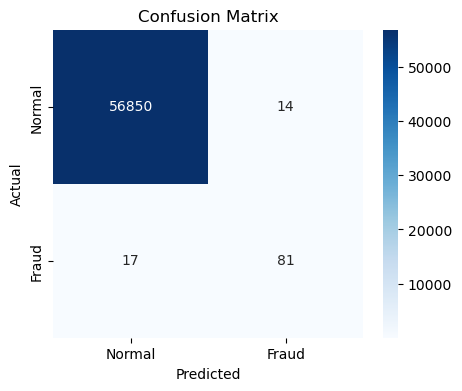

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8526    0.8265    0.8394        98

    accuracy                         0.9995     56962
   macro avg     0.9262    0.9131    0.9196     56962
weighted avg     0.9994    0.9995    0.9995     56962

ROC-AUC Score: 0.9683


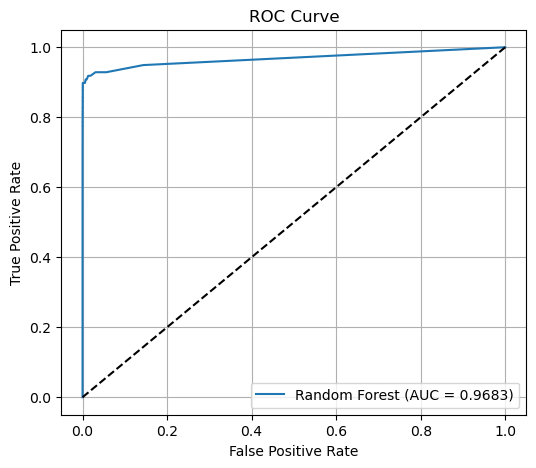

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Fraud'], yticklabels=['Normal','Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()